In [2]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn import metrics

import os
for dirname, _, filenames in os.walk('stock/'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))

/tmp/ipykernel_4406/1633172487.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


stock/BAX.csv
stock/AFL.csv
stock/ACN.csv
stock/AMP.csv
stock/ALLE.csv


In [4]:
from datetime import date

# df_aapl=pd.read_csv("../input/Data/Stocks/ibm.us.txt", parse_dates=True, index_col=0)
df = pd.read_csv('stock/BBVA.csv', parse_dates=True, index_col=0)

df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,8.55,8.49,8.52,8.54,2123100.0,6.864705
2018-01-03,8.55,8.47,8.49,8.54,2050600.0,6.864705
2018-01-04,8.77,8.67,8.68,8.68,2735000.0,6.977241
2018-01-05,8.77,8.66,8.70,8.77,2072500.0,7.049586
2018-01-08,8.69,8.65,8.67,8.67,1878400.0,6.969202
...,...,...,...,...,...,...
2022-10-10,4.51,4.42,4.48,4.46,2110100.0,4.460000
2022-10-11,4.48,4.37,4.42,4.37,1993600.0,4.370000
2022-10-12,4.45,4.39,4.42,4.43,1241800.0,4.430000


In [873]:
df = df[['Close']]

In [874]:
df=df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [877]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    print(data_raw.shape)
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
        
    data = np.array(data);
    # test_set_size = int(np.round(0.2*data.shape[0]));
    test_set_size = 180;
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

(1206, 1)
[array([[0.71631205],
       [0.71631205],
       [0.75602846],
       [0.78156042],
       [0.75319152],
       [0.75602846],
       [0.7957446 ],
       [0.81843962],
       [0.87517742],
       [0.8893616 ],
       [0.87517742],
       [0.87234048],
       [0.87517742],
       [0.92056745],
       [0.91489356],
       [0.93191496],
       [0.97730499],
       [1.        ],
       [0.99148944],
       [0.95744692]]), array([[0.71631205],
       [0.75602846],
       [0.78156042],
       [0.75319152],
       [0.75602846],
       [0.7957446 ],
       [0.81843962],
       [0.87517742],
       [0.8893616 ],
       [0.87517742],
       [0.87234048],
       [0.87517742],
       [0.92056745],
       [0.91489356],
       [0.93191496],
       [0.97730499],
       [1.        ],
       [0.99148944],
       [0.95744692],
       [0.95744692]]), array([[0.75602846],
       [0.78156042],
       [0.75319152],
       [0.75602846],
       [0.7957446 ],
       [0.81843962],
       [0.87517742]

In [732]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [733]:
y_train.size(), x_train.size()

(torch.Size([1006, 1]), torch.Size([1006, 19, 1]))

In [734]:
input_dim = 1
hidden_dim = 128
num_layers = 2
output_dim = 1

class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, num_layers=2, output_dim=1, dropout=0.2):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        h0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim))
        
        c0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim))
        
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # reshape output from hidden cell into [batch, features] for 'linear_2'
        x = self.dropout(x)
        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

model = LSTM(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1, dropout=0.2)
loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
# print(model)
# print(len(list(model.parameters())))
# for i in range(len(list(model.parameters()))):
#    print(list(model.parameters())[i].size())

In [735]:
''' linear and relu 
LSTM(
  (linear_1): Linear(in_features=1, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
12
torch.Size([32, 1])
torch.Size([32])
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])
'''

''' Normal
LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])
'''


' Normal\nLSTM(\n  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)\n  (dropout): Dropout(p=0.2, inplace=False)\n  (fc): Linear(in_features=32, out_features=1, bias=True)\n)\n10\ntorch.Size([128, 1])\ntorch.Size([128, 32])\ntorch.Size([128])\ntorch.Size([128])\ntorch.Size([128, 32])\ntorch.Size([128, 32])\ntorch.Size([128])\ntorch.Size([128])\ntorch.Size([1, 32])\ntorch.Size([1])\n'

In [736]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.01588861644268036
Epoch  20 MSE:  0.01258907001465559
Epoch  30 MSE:  0.006621608976274729
Epoch  40 MSE:  0.003801424754783511
Epoch  50 MSE:  0.0033122156746685505
Epoch  60 MSE:  0.002837443258613348
Epoch  70 MSE:  0.002603297121822834
Epoch  80 MSE:  0.002393072936683893
Epoch  90 MSE:  0.002254231134429574


In [737]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.16 RMSE
Test Score: 0.20 RMSE


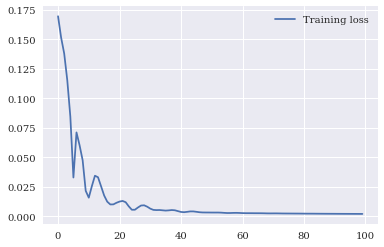

In [738]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [739]:
df[len(df)-len(y_test):].index

DatetimeIndex(['2022-01-28', '2022-01-31', '2022-02-01', '2022-02-02',
               '2022-02-03', '2022-02-04', '2022-02-07', '2022-02-08',
               '2022-02-09', '2022-02-10',
               ...
               '2022-10-03', '2022-10-04', '2022-10-05', '2022-10-06',
               '2022-10-07', '2022-10-10', '2022-10-11', '2022-10-12',
               '2022-10-13', '2022-10-14'],
              dtype='datetime64[ns]', name='Date', length=180, freq=None)

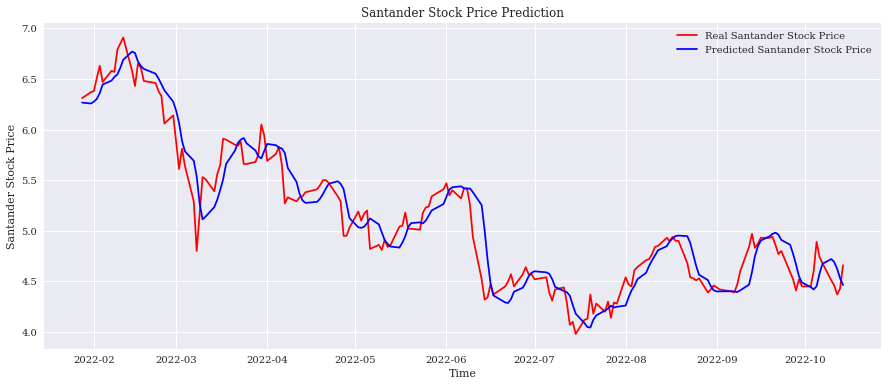

In [740]:
# Visualising the results
figure, ax = plt.subplots(figsize=(15, 6))
ax.xaxis_date()

ax.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'Real Santander Stock Price')
ax.plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Santander Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Santander Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Santander Stock Price')
plt.legend()
plt.savefig('aapl_pred.png')
plt.show()

In [899]:
df = pd.read_csv('stock/BBVA.csv')
df = df.loc[df['Date'] > "2022-09-19"]

df.set_index('Date')

df = df[['Close']]

df=df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [900]:
# function to create train, test data given stock data and sequence length
def load_data_test(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(0, len(data_raw)): 
        data.append(data_raw[index: index])

    data = np.array(data);
    # test_set_size = int(np.round(0.2*data.shape[0]));
    test = data[:,:-1]
    
    return [test]

look_back = 20

data = load_data_test(df, look_back)

,Close
1187,0.884616
1188,0.538462
1189,0.653847
1190,-0.153845
1191,-0.423077
1192,-0.846154
1193,-0.423077
1194,-0.692308
1195,-0.692308
1196,-0.115385
